<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day4/Day_4_4_RNN_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4.4 RNN Classfication model
### 실습 목표
- RNN 모델을 이용해 분류모델을 구현해보자

### Contents
1. RNN을 이용한 숫자 이미지 예측
  <details>
  - MNIST: 28*28, 70,000개 데이터로 구성

  ![img.png](https://nvsyashwanth.github.io/machinelearningmaster/assets/images/digitsMNIST/samples.png)
  </details>
2. RNN을 이용한 주가 예측
- `FinanceDataReader`: 한국, 미국 주식가격과 암호화폐 가격 등 금융 데이터 수집 라이브러리


## 0. Setting
- DL 관련 library 호출
- GPU 설정

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


## 1. RNN을 이용한 손글씨 예측
- RNN을 이용해 MNIST 숫자 이미지 데이터셋을 분류하는 분류기를 구현
- MNIST와 같은 이미지 데이터는 이미지의 공간(spatial) 구조를 활용하는 CNN 모델이 더 적합함.
- 하지만 인접한 영역의 픽셀은 서로 연관되어 있으므로 이를 시퀀스 데이터로 볼 수도 있음
- 아래의 그림처럼 MNIST 데이터에서 28 x 28 픽셀을 시퀀스의 각원소는 28개의 픽셀을 가진 길이가 28 시퀀스 데이터로 볼 수 있음.

![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F996759475BD2ACEF18)

### 1.1 데이터 셋 불러오기
#### Dataset: 샘플과 레이블 저장
- `root` 는 학습/테스트 데이터가 저장되는 경로입니다.

- `train` 은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.

- `download=True` 는 root 에 데이터가 없는 경우 인터넷에서 다운로드합니다.

- `transform`은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.

In [ ]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform)

### DataLoader
: Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싸는 역할

In [ ]:
from multiprocessing import cpu_count

In [ ]:
num_workers = int(cpu_count() / 2)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 1.2 모델 구성 및 학습
#### `torch.nn.RNN(input_size, hidden_size, batch_first)`
- [pytorch document](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- `input_size`: 입력해 주는 특성 값의 개수
- `hidden_size`: hidden state의 사이즈 지정. 보통 arbitrary 함.
- `batch_first`: 입력으로 받는 데이터의 shape중 첫 번째 차원을 batch로 간주할 것인지를 설정.
  - True: (batch, seq, feature)
  - False: (seq, batch, feature)

In [ ]:
class ImageRNN(torch.nn.Module):
    def __init__(self, batch_size, seq_length, input_size, hidden_size, num_classes, device):
        super(ImageRNN, self).__init__()
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # make rnn
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        # make fully-connected
        self.fc = torch.nn.Linear(seq_length*hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, self.seq_length, self.input_size)
        x, _hidden = self.rnn(x)
        x = x.reshape(-1, (self.seq_length * self.hidden_size))
        out = self.fc(x)

        return out

### Quiz 1
- Practice 1. Image를 RNN 모델의 input으로 넣을 때, `??`안의 파라미터를 정의하시오.
- Practice 2. practice1에서 정의한 파라미터로 train/test를 진행해보고 각각의 accuracy를 확인하시오.

In [ ]:
# parameters
seq_length = ??
input_size = ??
hidden_size = 30
num_classes = ??
epochs = 5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = ImageRNN(batch_size, seq_length, input_size, hidden_size, num_classes, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# %%time

for epoch in range(epochs):
    # Train
    model.train()

    train_loss = 0
    train_correct = 0

    for x, y in trainloader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = train_correct / len(trainset)

    print('[%2d] TRAIN loss: %.3f, acc: %.3f' % (epoch+1, train_loss, train_acc))

[ 1] TRAIN loss: 0.391, acc: 0.887
[ 2] TRAIN loss: 0.197, acc: 0.941
[ 3] TRAIN loss: 0.142, acc: 0.958
[ 4] TRAIN loss: 0.112, acc: 0.966
[ 5] TRAIN loss: 0.094, acc: 0.971


In [ ]:
# Test
model.eval()

test_loss = 0
test_correct = 0
test_preds = []

with torch.no_grad():
    for i, (x, y) in enumerate(testloader):
        x = x.view(-1, 28, 28)

        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(y).sum().item()

        if i == 0:
            test_preds = predicted
        else:
            test_preds = torch.cat((test_preds, predicted), dim=0)

test_preds = test_preds.cpu()

print('TEST loss: %.4f, acc: %.4f' % (test_loss/len(testloader), test_correct/len(testset)))

TEST loss: 0.0788, acc: 0.9754


In [ ]:
print(test_preds[:20])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [ ]:
print(testset.targets[:20])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


## 2. RNN을 이용한 주가 예측

- 과거 n일 동안의 주식 데이터를 보고, 미래의 주가를 예측해봅시다.




## 0. Setting
- DL 관련 library 호출
- GPU 설정

In [ ]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import FinanceDataReader as fdr
import seaborn as sns
import pandas as pd

### 2.1 데이터 셋 불러오기
- `FinanceDataReader`는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지
- [docs](https://financedata.github.io/posts/finance-data-reader-users-guide.html)

#### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비


In [ ]:
import FinanceDataReader as fdr

df = fdr.DataReader('BTC/KRW', '2021')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,31477346.0,32136216.0,31270612.0,31892398.0,31892398.0,44222110093971
2021-01-02,31894900.0,35997508.0,31585168.0,34881540.0,34881540.0,73683523287436
2021-01-03,34883860.0,37575548.0,34800164.0,35641816.0,35641816.0,85527720971149
2021-01-04,35673264.0,36138520.0,31086118.0,34743756.0,34743756.0,88200032849594
2021-01-05,34749328.0,37442220.0,32857940.0,36965032.0,36965032.0,73454269908133


Text(0, 0.5, 'price')

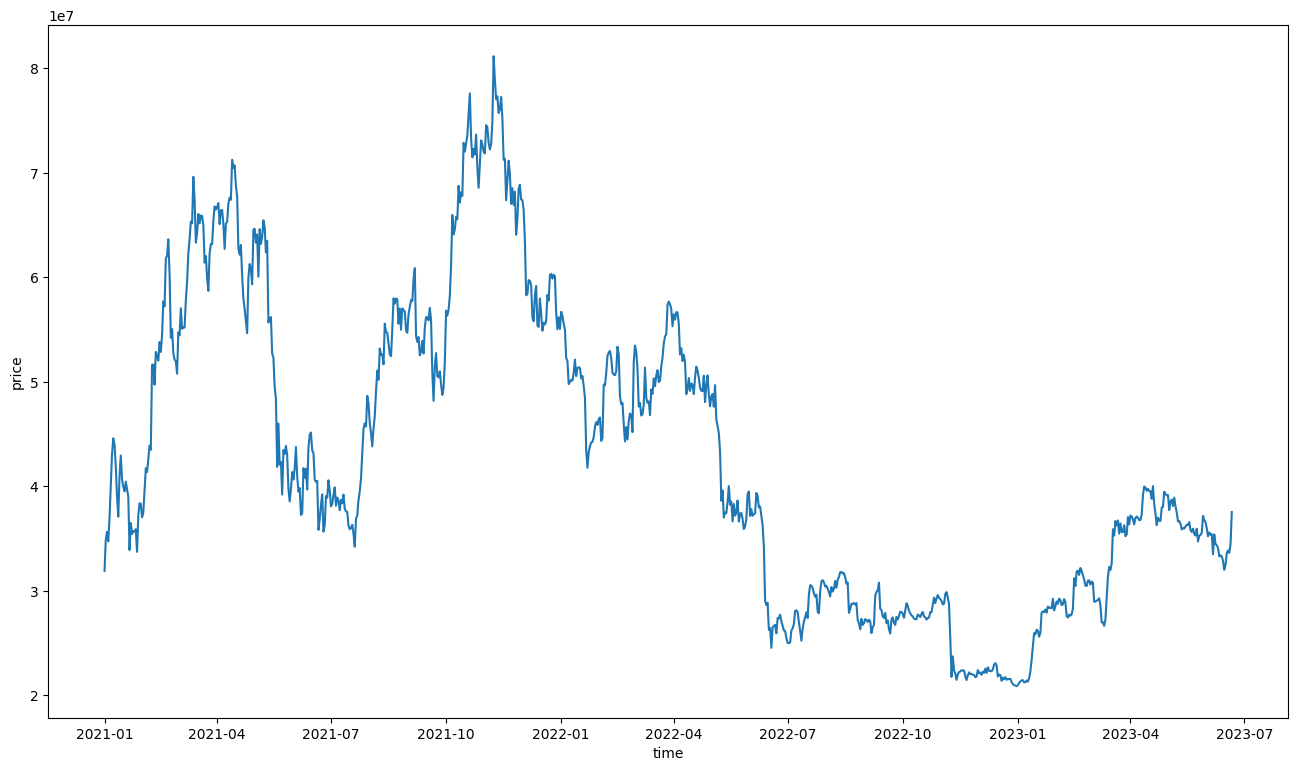

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

### 2.2 데이터 전처리
- 특성별로 값의 범위가 다 다르기때문에 정규화를 하지 않고 학습을 바로 할 경우 원하지 않는 방향으로 학습될 수 있음.
- 주가 데이터에 대해 모델이 더 잘 학습할 수 있도록 `정규화(Normalization)`를 진행
- `MinMaxScaler`를 사용하여 0~1사이로 모든 값을 정규화
- [docs](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,0.175898,0.185706,0.185213,0.182733,31892398.0,0.090506
2021-01-02,0.182830,0.250002,0.190666,0.232340,34881540.0,0.166938
2021-01-03,0.232451,0.276279,0.246407,0.244957,35641816.0,0.197666
2021-01-04,0.245556,0.252350,0.182014,0.230053,34743756.0,0.204599
2021-01-05,0.230217,0.274058,0.212733,0.266917,36965032.0,0.166343
...,...,...,...,...,...,...
2023-06-17,0.192713,0.213742,0.201491,0.211538,33628068.0,0.029875
2023-06-18,0.211629,0.219947,0.222698,0.215421,33862088.0,0.012530
2023-06-19,0.215483,0.217959,0.226056,0.211671,33636124.0,0.007475


In [ ]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length): # sequence_length는 time window로, 과거를 며칠 볼건지에 대한 변수
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # i~i+seq_len-1 기간 동안의 가격을 보고
    y_seq.append(y[i + sequence_length]) # i~i+seq_len 기간의 가격을 맞추는게 목표!

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(DEVICE), torch.FloatTensor(y_seq).to(DEVICE).view(-1,1)

### 2.3 Train/Test dataset 분할
- train:test = 8:2로 분할

In [ ]:
split = int(len(x)*0.8) # len(x)에 따라 적당히 8:2비율로 split 값 설정
sequence_length=5
x_seq, y_seq = seq_data(x, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([721, 5, 4]) torch.Size([721, 1])
torch.Size([176, 5, 4]) torch.Size([176, 1])


In [ ]:
# 5일 단위로 각 변수들의 값이 묶여서 저장되어 있음.
x_train_seq

tensor([[[0.1759, 0.1857, 0.1852, 0.0905],
         [0.1828, 0.2500, 0.1907, 0.1669],
         [0.2325, 0.2763, 0.2464, 0.1977],
         [0.2456, 0.2523, 0.1820, 0.2046],
         [0.2302, 0.2741, 0.2127, 0.1663]],

        [[0.1828, 0.2500, 0.1907, 0.1669],
         [0.2325, 0.2763, 0.2464, 0.1977],
         [0.2456, 0.2523, 0.1820, 0.2046],
         [0.2302, 0.2741, 0.2127, 0.1663],
         [0.2674, 0.3187, 0.2743, 0.1883]],

        [[0.2325, 0.2763, 0.2464, 0.1977],
         [0.2456, 0.2523, 0.1820, 0.2046],
         [0.2302, 0.2741, 0.2127, 0.1663],
         [0.2674, 0.3187, 0.2743, 0.1883],
         [0.3186, 0.3835, 0.3317, 0.2164]],

        ...,

        [[0.0086, 0.0144, 0.0137, 0.0515],
         [0.0137, 0.0125, 0.0153, 0.0252],
         [0.0110, 0.0095, 0.0136, 0.0309],
         [0.0144, 0.0112, 0.0172, 0.0267],
         [0.0103, 0.0101, 0.0158, 0.0081]],

        [[0.0137, 0.0125, 0.0153, 0.0252],
         [0.0110, 0.0095, 0.0136, 0.0309],
         [0.0144, 0.0112, 0.0172

In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)


### DataLoader를 이용하여 배치 형태로 변경.
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

### 2.4 모델 정의
- VanillaRNN
- LSTM

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=DEVICE).to(DEVICE)

In [ ]:
# 손실함수 및 최적화 방법 정의
criterion = nn.MSELoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 2.5 모델 학습

In [ ]:
loss_graph = []
n = len(train_loader)

model.train()
for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))


[epoch : 0] loss: 0.0512
[epoch : 10] loss: 0.0039
[epoch : 20] loss: 0.0034
[epoch : 30] loss: 0.0029
[epoch : 40] loss: 0.0027
[epoch : 50] loss: 0.0026
[epoch : 60] loss: 0.0019
[epoch : 70] loss: 0.0016
[epoch : 80] loss: 0.0015
[epoch : 90] loss: 0.0016


### 2.6 실제값과 예측값 그래프로 비교

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

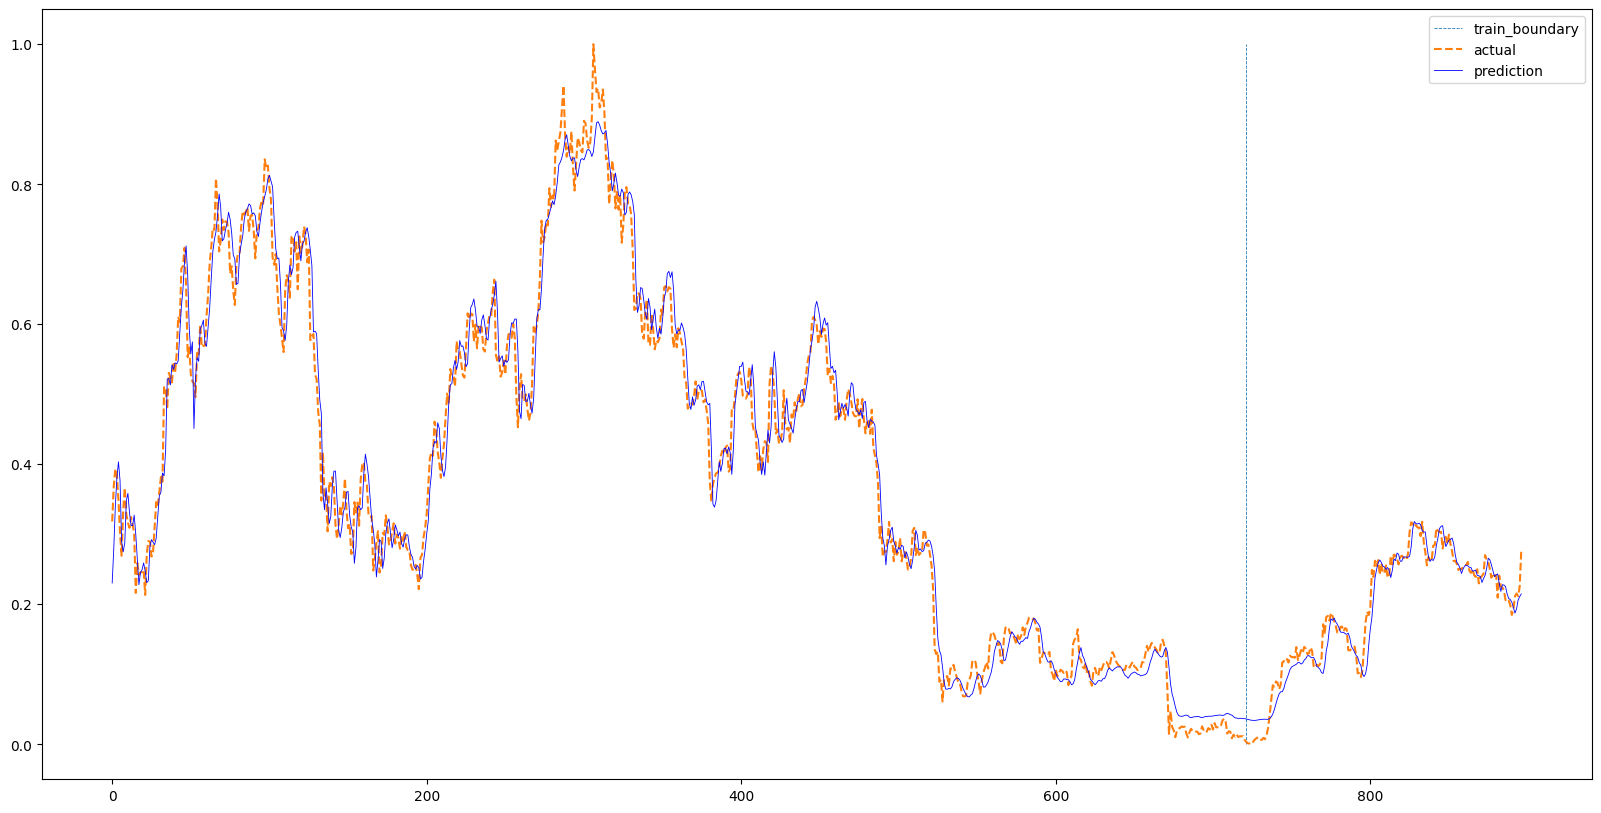

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()